In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install tensorflow scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.1 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 3.0.5
    Uninstalling keras-3.0.5:
      Successfully uninstalled keras-3.0.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, concatenate, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 100  # Reduce epochs
NUM_CLASSES = 3

# Define data directories
train_dir = '/kaggle/input/ct-scan-data/ct images/train'
val_dir = '/kaggle/input/ct-scan-data/ct images/val'
test_dir = '/kaggle/input/ct-scan-data/ct images/test'

# Data preprocessing with more augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

2024-04-04 12:59:03.975441: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 12:59:03.975538: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 12:59:04.110726: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 1947 images belonging to 3 classes.
Found 233 images belonging to 3 classes.
Found 422 images belonging to 3 classes.


In [3]:
import numpy as np
import keras
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
import numpy as np
import os
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.preprocessing.image import ImageDataGenerator
import os
import zipfile
import tensorflow as tf
import numpy as np
import keras
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D,AveragePooling2D# convolution layers
from keras.layers import Dense, Dropout, Flatten,Activation,Reshape # core layers1
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras import regularizers
from tensorflow import keras
from keras.models import Model
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten, Reshape, GlobalAveragePooling2D, Dropout
from keras.layers import multiply
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19
from keras import regularizers
from keras.layers import Conv2D, BatchNormalization, Activation, Input, Concatenate
from keras.layers import DepthwiseConv2D, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import VGG19
from keras.applications import VGG19
from keras.layers import Input, Conv2D, Conv2DTranspose, Concatenate

In [6]:
def dynamic_filter_layer(input_tensor, num_filters, filter_size, dynamic_weights):
    dynamic_weights = tf.reshape(dynamic_weights, (1, 1, 1, num_filters))
    dynamic_weights = tf.nn.softmax(dynamic_weights, axis=3)

    # Create a 1x1 convolution layer with trainable weights
    dynamic_conv = Conv2D(num_filters, (1, 1), activation=None, use_bias=False, trainable=True)(input_tensor)

    # Apply dynamic weights to the 1x1 convolution result
    dynamic_conv = dynamic_conv * dynamic_weights

    # Apply a regular 2D convolution with the dynamic filters
    dynamic_conv_result = Conv2D(num_filters, (filter_size, filter_size), strides=(1, 1), padding='same')(dynamic_conv)

    return dynamic_conv_result 


from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.models import Model

def createModel():
    input_shape = (224, 224, 3)
    base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)

    # Freeze the weights of the InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(3, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model

model = createModel()

In [10]:
from tensorflow.keras.optimizers import Adam

# Define the new learning rate
new_lr = 0.0001

# Create an instance of the Adam optimizer with the new learning rate
optimizer = Adam(learning_rate=new_lr)

# Compile the model with the updated optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Adding callbacks for learning rate reduction and early stopping
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
#early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the combined model
history = model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator, callbacks=[reduce_lr, early_stop])

Epoch 1/100
122/122 [==============================] - 37s 253ms/step - loss: 0.1194 - accuracy: 0.9584 - val_loss: 0.3295 - val_accuracy: 0.8541 - lr: 1.0000e-04
Epoch 2/100
122/122 [==============================] - 28s 228ms/step - loss: 0.0935 - accuracy: 0.9630 - val_loss: 0.1751 - val_accuracy: 0.9313 - lr: 1.0000e-04
Epoch 3/100
122/122 [==============================] - 28s 226ms/step - loss: 0.1142 - accuracy: 0.9533 - val_loss: 0.2010 - val_accuracy: 0.9099 - lr: 1.0000e-04
Epoch 4/100
122/122 [==============================] - 28s 232ms/step - loss: 0.1127 - accuracy: 0.9553 - val_loss: 0.1712 - val_accuracy: 0.9270 - lr: 1.0000e-04
Epoch 5/100
122/122 [==============================] - 28s 230ms/step - loss: 0.0978 - accuracy: 0.9625 - val_loss: 0.1309 - val_accuracy: 0.9399 - lr: 1.0000e-04
Epoch 6/100
122/122 [==============================] - 28s 227ms/step - loss: 0.0863 - accuracy: 0.9651 - val_loss: 0.1687 - val_accuracy: 0.9185 - lr: 1.0000e-04
Epoch 7/100
122/122 [=

In [11]:
# Evaluate the model on the test set
# Load the best model
#best_model = keras.models.load_model('best_model.h5')

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

27/27 [==============================] - 3s 105ms/step - loss: 0.3740 - accuracy: 0.9242
Test Loss: 0.3740139901638031, Test Accuracy: 0.9241706132888794


In [12]:
from sklearn.metrics import classification_report, confusion_matrix

# Assuming you have the model 'best_model' loaded and 'test_generator' ready

# Predict the labels on the test set
y_pred = model.predict(test_generator)

# Convert probabilities to class predictions
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))

27/27 [==============================] - 4s 92ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       0.83      0.93      0.88       123
           2       0.95      0.88      0.92       199

    accuracy                           0.92       422
   macro avg       0.93      0.94      0.93       422
weighted avg       0.93      0.92      0.92       422

Confusion Matrix:
[[100   0   0]
 [  0 114   9]
 [  0  23 176]]


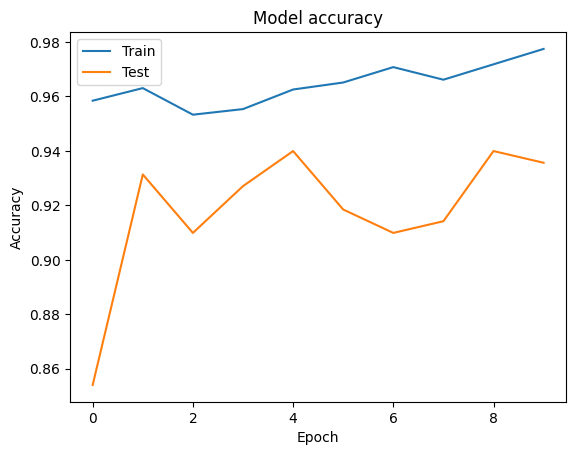

27/27 [==============================] - 3s 94ms/step


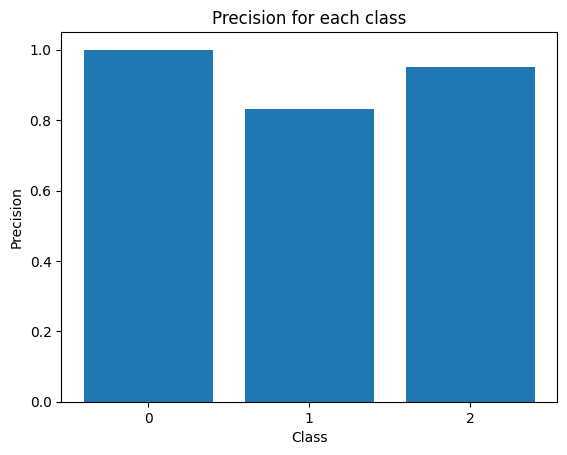

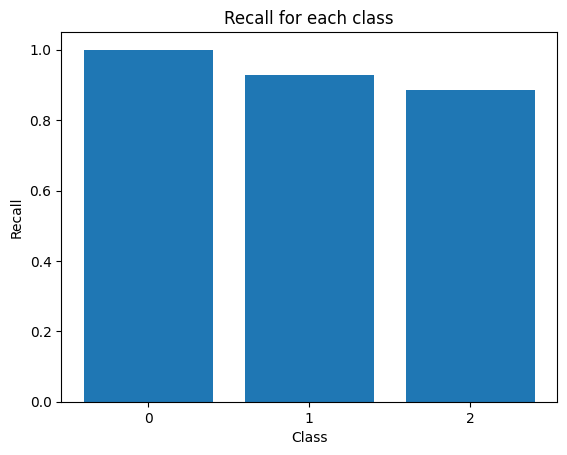

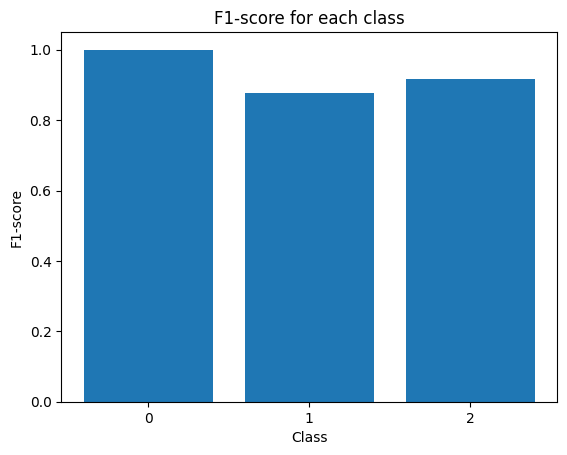

In [13]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
from sklearn.metrics import precision_recall_fscore_support
# Assuming you have the model 'best_model' loaded and 'test_generator' ready

# Predict the labels on the test set
y_pred = model.predict(test_generator)

# Convert probabilities to class predictions
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Calculate precision, recall, and F1-score for each class
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average=None)

# Create a bar plot for precision
plt.bar(range(len(precision)), precision, tick_label=range(len(precision)))
plt.title('Precision for each class')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.show()

# Create a bar plot for recall
plt.bar(range(len(recall)), recall, tick_label=range(len(recall)))
plt.title('Recall for each class')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.show()

# Create a bar plot for F1-score
plt.bar(range(len(f1_score)), f1_score, tick_label=range(len(f1_score)))
plt.title('F1-score for each class')
plt.xlabel('Class')
plt.ylabel('F1-score')
plt.show()